<h2>Tokenization

- `Assign Character labels and spaces to cut points`
- `Apply BPE`

In [2]:
#libraries

import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import manifold
from sklearn import metrics
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import urllib.request
import shutil
import zipfile
import utils
from transformers import AutoTokenizer
import string

pd.options.display.max_rows = 999
pd.options.display.max_colwidth = None

# For reproducibility
np.random.seed(42)
N_JOBS = 2


/home/hrs675/Wearables_Tokenizer/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Import data

In [2]:
#magnitude cuts for tokens
cut_points_df=pd.read_csv("cut_points.csv")


In [3]:
data = utils.load_data('/data/UKBB/kyra/capture24/P001.csv.gz')
X, Y, T = utils.make_windows(data, winsec=10)

<h4> Assign Labels

In [59]:

# Function to assign the label corresponding to the highest absolute cut
def assign_label(mean_values, cuts, labs):

    assigned_labels = []
    for value in mean_values:
        # Find the cuts that the value passes through
        passed_cuts = cuts[np.abs(cuts) <= np.abs(value)]
        # Assign the label corresponding to the cut with the highest absolute value
        if len(passed_cuts) > 0:
            # Use np.isclose to find the index of the cut
            cut_index = np.where(np.isclose(cuts, passed_cuts[-1]))[0][0]
            assigned_labels.append(labs[cut_index])
        else:
            assigned_labels.append('A')  # Default to 'A' for 0
    return assigned_labels



<h2> Mean Magnitude Driven Cuts

In [7]:
cut_points_df

,arbitrary_cuts,sd_cuts,ci_cuts
0,-0.990684,-0.759364,-0.990684
1,-0.292509,-0.604944,-0.640305
2,0.405666,-0.450523,-0.289926
3,1.103841,-0.373313,-0.252093
4,1.802016,-0.296103,-0.214260
5,2.500191,-0.218893,-0.176427
6,3.198366,-0.141683,-0.138594
7,3.896541,-0.064472,-0.100761
8,4.594716,-0.013239,-0.062928
9,5.292891,0.000221,-0.025095


Arbitary

In [8]:
cuts_a= cut_points_df['arbitrary_cuts']
labs_a=list(string.ascii_lowercase[:len(cuts_a)])

Average & Standard Deviation driven

In [33]:
cuts_s = cut_points_df['sd_cuts']
cuts_s = cut_points_df['sd_cuts'].dropna()
labs_s = list(string.ascii_lowercase[:len(cuts_s)])

Confidence Interval Driven

In [10]:
cuts_c = cut_points_df['ci_cuts']
labs_c = list(string.ascii_lowercase[:len(cuts_c)])

<h4>Compression /Windows

10 seconds

In [11]:
X, Y, T = utils.make_windows(data, winsec=10)

In [12]:
M = np.linalg.norm(X, axis=2)

M_norm= M-1

mean_m= np.mean(M_norm, axis=1)


In [13]:
print(mean_m.shape)

(5635,)


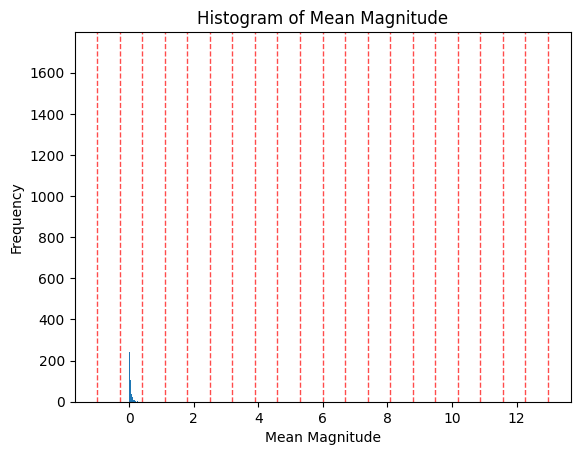

In [14]:
plt.hist(mean_m, bins=100)
plt.xlabel('Mean Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Magnitude')

# Plot vertical lines for each cut point
for cut in cuts_a:
    plt.axvline(cut, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.show()

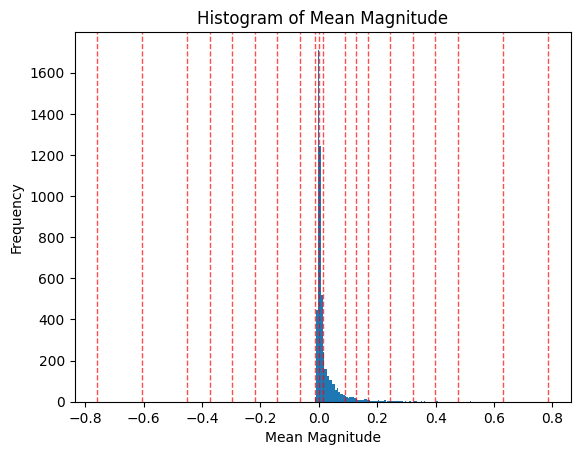

In [15]:
plt.hist(mean_m, bins=100)
plt.xlabel('Mean Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Magnitude')

# Plot vertical lines for each cut point
for cut in cuts_s:
    plt.axvline(cut, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.show()

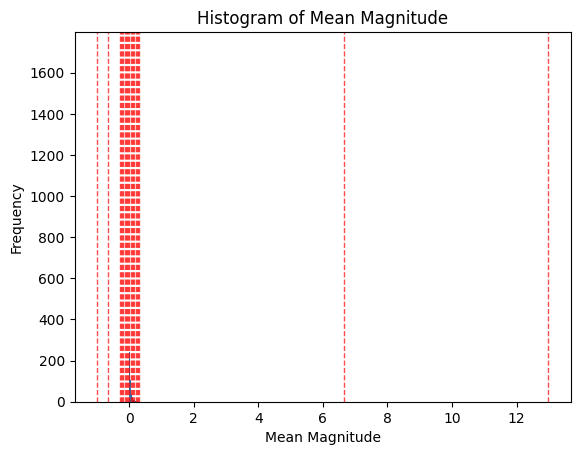

In [16]:
plt.hist(mean_m, bins=100)
plt.xlabel('Mean Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Magnitude')

# Plot vertical lines for each cut point
for cut in cuts_c:
    plt.axvline(cut, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.show()

<h3> Different Cut Points

In [60]:
def assign_labels(values, cuts, labels):

    """
    Assigns to each value the label corresponding to the cut point closest to it.
    The cut point closest to 0 is always assigned the label ' ' (space).
    """
    cuts = np.array(cuts)
    labels = np.array(labels)

    # Find the cut point closest to 0 and set its label to ' '
    idx_zero = np.argmin(np.abs(cuts))
    labels = labels.copy()  # avoid modifying input
    labels[idx_zero] = ' '

    assigned = []
    for v in values:
        idx = np.argmin(np.abs(cuts - v))
        assigned.append(labels[idx])
    return assigned

In [9]:
import re

def labels_to_string(labels):
    """
    Convert a list of labels to a string, collapsing consecutive spaces into a single space.
    """
    s = ''.join(labels)
    return re.sub(r' +', ' ', s)


In [54]:
labels_a=assign_labels(mean_m, cuts_a, labs_a)
string_a=labels_to_string(labels_a)

NameError: name 'mean_m' is not defined

In [40]:
labels_s=assign_labels(mean_m, cuts_s, labs_s)
string_s=labels_to_string(labels_s)

In [41]:
labels_c=assign_labels(mean_m, cuts_c, labs_c)
string_c=labels_to_string(labels_c)

<h4>BPE 

In [ ]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

# Build the tokenizer
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.BpeTrainer(vocab_size=8000, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
corpus_iterator= string_c.split()


# Train on your own corpus
tokenizer.train_from_iterator(corpus_iterator, trainer)

# Encode
output = tokenizer.encode(string_c)
print(output.tokens)
print(len(output.ids))



['jjjjjjjjjjjjjjjjjj', 'j', 'jjjjjjjjj', 'm', 'jjj', 'jj', 'jj', 'j', 'jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj', 'jjjj', 'jjjjjj', 'jjjj', 'j', 'jjjjj', 'jj', 'jj', 's', 's', 'm', 'l', 'j', 'mml', 'nllll', 'jr', 'l', 'lll', 'll', 'l', 'l', 'jj', 'lll', 'l', 'l', 'l', 'j', 'j', 'l', 'l', 'mmplmomll', 'm', 'l', 'll', 'lll', 'mml', 'mlommqllllll', 'noomnllonlsomrosnmnl', 'll', 'llll', 'l', 'l', 'l', 'l', 'l', 'ml', 'lm', 'l', 'l', 'll', 'lll', 'mmqsp', 'l', 'l', 'l', 'lsspqlll', 'l', 'll', 'lmomlnoqqrspqsool', 'l', 'l', 'lllmoosqsonnqnoolpsrolmqprqssrlll', 'l', 'omllnmolmnlllllllmmmplmm', 'l', 'llmlllmlmllnollml', 'lllllll', 'l', 'llqnmq', 'mmmmnnllnlnnopormlnn', 'll', 'j', 'mloll', 'l', 'jjjjjj', 'j', 'jjj', 'l', 'l', 'll', 'l', 'l', 'l', 'l', 'l', 'll', 'lmnnl', 'qmr', 'l', 'l', 'l', 'l', 'l', 'nppsrll', 'nnorsponl', 'j', 'mlll', 'l', 'j', 'ml', 'lm', 'jj', 'j', 'm', 'm', 'llll', 'lmll', 'j', 'l', 'l', 'lllm', 'lllllllnmmlmmmmmmmmmmmmmmnmmmmmmmmmmmmmmollllnl', 'lll', 'llllllmm

Distribution of tokens

In [ ]:
encoded_outputs = [tokenizer.encode(text) for text in corpus_iterator]
token_ids = [token for enc in encoded_outputs for token in enc.ids]

In [ ]:
from collections import Counter

token_counts = Counter(token_ids)

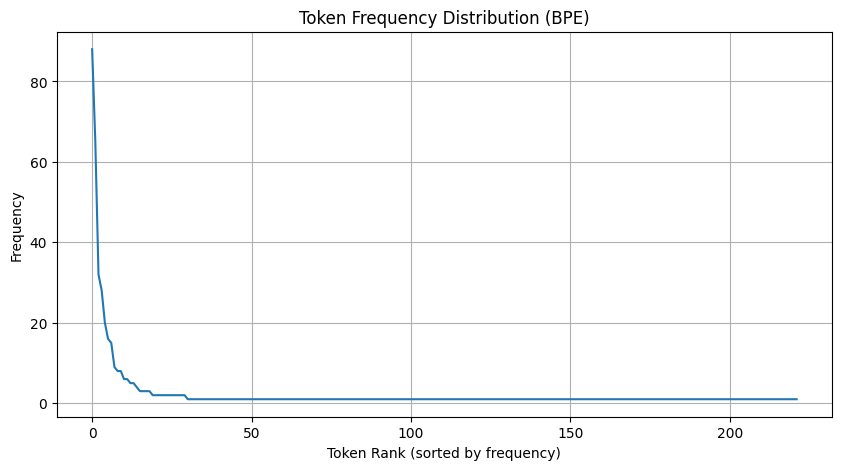

In [79]:
import matplotlib.pyplot as plt

# Sort tokens by frequency
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
token_ids_sorted, frequencies = zip(*sorted_tokens)

plt.figure(figsize=(10, 5))
plt.plot(frequencies)
plt.xlabel("Token Rank (sorted by frequency)")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE)")
plt.grid(True)
plt.show()


<h2>Iterate through all Participants

Create a one hour set of tokens for each participant, save each string into a csv.


Downstreaam aim- combine each string with sex data.Train and test RNN on similar. 

<h5> Functions

In [ ]:
def wearable_tokenizer_trianer(X, cuts, tokenizer, trainer):
    M = np.linalg.norm(X, axis=2)
    norm_M = M - 1
    window_mean = np.mean(norm_M, axis=1)
    labs = list(string.ascii_lowercase[:len(cuts)])
    labels = assign_labels(window_mean, cuts, labs)
    result_string = labels_to_string(labels)
    corpus_iterator = result_string.split()
    tokenizer.train_from_iterator(corpus_iterator, trainer)
    return tokenizer

In [ ]:
def wearable_tokenizer(X, cuts, tokenizer):
    """
    Given input X, cut points, and a trained tokenizer,
    returns the encoded output for the generated string.
    """
    M = np.linalg.norm(X, axis=2)
    norm_M = M - 1
    window_mean = np.mean(norm_M, axis=1)
    labs = list(string.ascii_lowercase[:len(cuts)])
    labels = assign_labels(window_mean, cuts, labs)
    result_string = labels_to_string(labels)
    # Encode the generated string
    output = tokenizer.encode(result_string)
    return output

Make Corpus of All particpants

In [ ]:
#iterate through all of the particpants, make a string add to corpus, train tokenizer on that corpius, then iterate again to encode each string. then evaluate on the tokenized strings.

In [64]:
corpus_s=[]

cuts= cuts_s

for i in os.listdir("/data/UKBB/kyra/capture24/"):

    if i.startswith("P") and i.endswith(".csv.gz"):

        data = utils.load_data(f'/data/UKBB/kyra/capture24/{i}')  # Use the current file name
        
        X, Y, T = utils.make_windows(data, winsec=10)
        M = np.linalg.norm(X, axis=2)
        norm_M = M - 1
        window_mean = np.mean(norm_M, axis=1)
        labs = list(string.ascii_lowercase[:len(cuts)])
        labels = assign_labels(window_mean, cuts, labs)
        result_string = labels_to_string(labels)
        corpus_s.append(result_string)  


corpus_c=[]

cuts= cuts_c

for i in os.listdir("/data/UKBB/kyra/capture24/"):

    if i.startswith("P") and i.endswith(".csv.gz"):

        data = utils.load_data(f'/data/UKBB/kyra/capture24/{i}')  # Use the current file name
        
        X, Y, T = utils.make_windows(data, winsec=10)
        M = np.linalg.norm(X, axis=2)
        norm_M = M - 1
        window_mean = np.mean(norm_M, axis=1)
        labs = list(string.ascii_lowercase[:len(cuts)])
        labels = assign_labels(window_mean, cuts, labs)
        result_string = labels_to_string(labels)
        corpus_c.append(result_string)  

In [67]:
import pandas as pd

# Save the list of strings (one per participant) to a CSV file
df = pd.DataFrame({'token_string': corpus_s})
df.to_csv('corpus_s.csv', index=False)

In [68]:
import pandas as pd

# Save the list of strings (one per participant) to a CSV file
df = pd.DataFrame({'token_string': corpus_c})
df.to_csv('corpus_c.csv', index=False)

Note, each line relates to a participant.


In [ ]:
pid=[]

for i in os.listdir("/data/UKBB/kyra/capture24/"):

    if i.startswith("P") and i.endswith(".csv.gz"):

        pid.append(i)       
        

In [73]:
import pandas as pd

# Save the list of participant IDs and their token strings to a CSV file
df = pd.DataFrame({'pid': pid})
df.to_csv('pids.csv', index=False)

Train Tokenizer on corpi

In [ ]:
corpus_c_joined= " ".join(corpus_c)
corpus_s_joined= " ".join(corpus_s)

In [ ]:
# Build the tokenizer
tokenizer_c = Tokenizer(models.BPE())
tokenizer_c.pre_tokenizer = pre_tokenizers.Whitespace()

trainer_c = trainers.BpeTrainer(vocab_size=1000, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
corpus_iterator_c= corpus_c_joined.split()


# Train on your own corpus
tokenizer_c.train_from_iterator(corpus_iterator_c, trainer)

# Encode
output_c = tokenizer_c.encode(string_c)
print(output_c.tokens)
print(len(output_c.ids))




['jjjjjjjjjjjjjjjjjj', 'j', 'jjjjjjjjj', 'm', 'jjj', 'jj', 'jj', 'j', 'jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj', 'jjjj', 'jjjjjj', 'jjjj', 'j', 'jjjjj', 'jj', 'jj', 's', 's', 'm', 'l', 'j', 'mml', 'nllll', 'j', 'r', 'l', 'lll', 'll', 'l', 'l', 'jj', 'lll', 'l', 'l', 'l', 'j', 'j', 'l', 'l', 'mmp', 'lmo', 'mll', 'm', 'l', 'll', 'lll', 'mml', 'ml', 'omm', 'q', 'llllll', 'noo', 'mn', 'llo', 'nl', 'som', 'ro', 's', 'nmnl', 'll', 'llll', 'l', 'l', 'l', 'l', 'l', 'ml', 'lm', 'l', 'l', 'll', 'lll', 'mm', 'q', 'sp', 'l', 'l', 'l', 'lss', 'pq', 'lll', 'l', 'll', 'lmo', 'mlno', 'qq', 'rs', 'pq', 'soo', 'l', 'l', 'l', 'lllmoo', 'sq', 'so', 'nn', 'q', 'noo', 'lp', 'sr', 'olm', 'qp', 'rq', 'ssr', 'lll', 'l', 'omll', 'nmo', 'lmn', 'lllllll', 'mmm', 'plmm', 'l', 'llmlllm', 'lmll', 'no', 'llml', 'lllllll', 'l', 'llq', 'nmq', 'mmmm', 'nn', 'llnl', 'nno', 'po', 'rml', 'nn', 'll', 'j', 'ml', 'oll', 'l', 'jjjjjj', 'j', 'jjj', 'l', 'l', 'll', 'l', 'l', 'l', 'l', 'l', 'll', 'lm', 'nnl', 'qm', 'r'

In [82]:
# Build the tokenizer
tokenizer_s = Tokenizer(models.BPE())
tokenizer_s.pre_tokenizer = pre_tokenizers.Whitespace()

trainer_s = trainers.BpeTrainer(vocab_size=1000, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
corpus_iterator_s= corpus_s_joined.split()


# Train on your own corpus
tokenizer_s.train_from_iterator(corpus_iterator_s, trainer)

# Encode
output_s = tokenizer_s.encode(string_s)
print(output_s.tokens)
print(len(output_s.ids))




['iiiiiiiiiiiiiii', 'k', 'iiiiiiiii', 'kl', 'kkii', 'ii', 'i', 'i', 'i', 'i', 'iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii', 'ii', 'iiiiii', 'i', 'kiiii', 'i', 'i', 'r', 'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk', 'kkkkkkkkkkkkkkkkkkkkkkkkkkk', 'k', 'r', 'kkkkkkkkkkkkkkkkkk', 'k', 'kkkkkkkkkkkkkkkkkkkkkk', 'k', 'klkkkk', 'i', 'llk', 'ml', 'kklkkkk', 'k', 'ki', 'ok', 'k', 'kk', 'kk', 'kkl', 'kkllk', 'k', 'kkkkkklk', 'lk', 'kk', 'kklkl', 'kkkkkkkkkkkk', 'kkkkkkk', 'k', 'i', 'k', 'k', 'k', 'k', 'kk', 'ikkkkkkkk', 'll', 'nll', 'nl', 'kkklkk', 'klkl', 'kkkkkll', 'kkklk', 'nll', 'okll', 'kklk', 'mnnl', 'mlk', 'nml', 'p', 'nl', 'onp', 'mlmk', 'kk', 'kkkkkkkkk', 'l', 'kklkkk', 'kkkkkkkl', 'kkkkkkkkk', 'kklkk', 'klkkkkkkkkkkkkkkkk', 'kkll', 'oqo', 'k', 'kkk', 'kklklkkl', 'qp', 'oo', 'kkl', 'kkkkkklkk', 'kkl', 'nlk', 'mn', 'oo', 'pp', 'oop', 'nn', 'kklkkkkk', 'lll', 'nn', 'po', 'q', 'nmm', 'ol', 'nn', 'kn', 'pp', 'mll', 'onoo', 'rqp', 'kkl', 'kkkkkkk', 'kkn', 'llk', 'mlnll', 'mkklll', 'kklll', 'nlll

<h5>
Iterate

In [92]:
# Tokenize each entry in corpus_c using the trained tokenizer_c
tokenized_c = [tokenizer_c.encode(i) for i in corpus_c]
tokenized_s=  [tokenizer_s.encode(i) for i in corpus_s]

<h3> Exploratory Analysis of Tokens

Confidence interval tokens

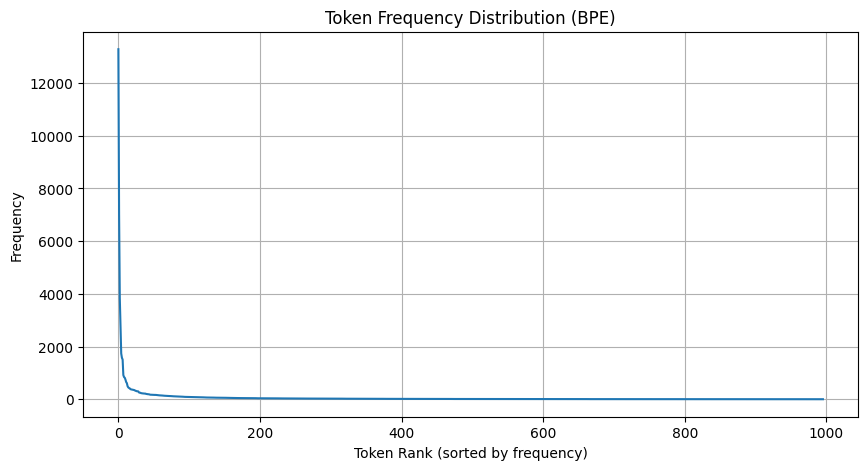

In [105]:

# Flatten all token ids from all entries in tokenized_c
all_token_ids_c = [token_id for entry in tokenized_c for token_id in entry.ids]

# Count frequency of each token id
token_counts_c = Counter(all_token_ids_c)

# Sort tokens by frequency
sorted_tokens_c = sorted(token_counts_c.items(), key=lambda x: x[1], reverse=True)
token_ids_sorted_c, frequencies = zip(*sorted_tokens_c)

plt.figure(figsize=(10, 5))
plt.plot(frequencies)
plt.xlabel("Token Rank (sorted by frequency)")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE)")
plt.grid(True)
plt.show()

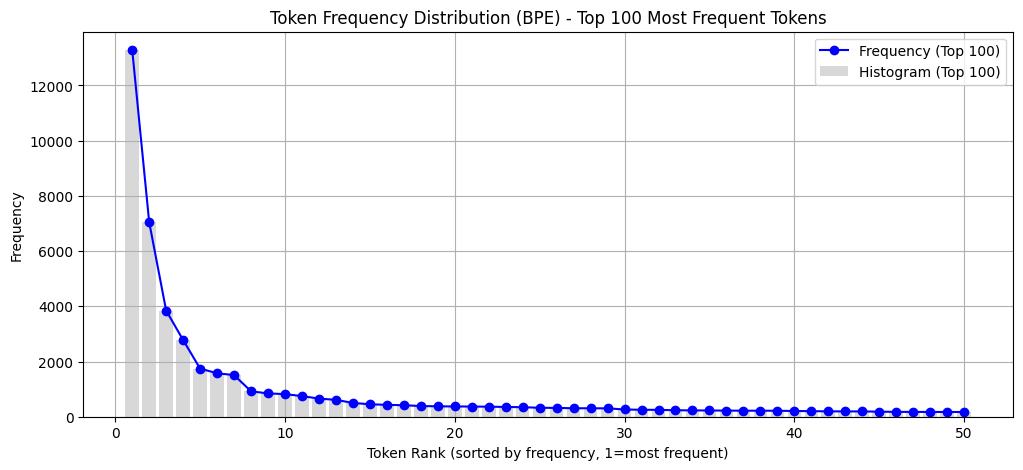

In [ ]:
# Get the top 100 most frequent tokens and their frequencies (already sorted by frequency)
top_100 = sorted_tokens_c[:50]
top_token_ids_c, top_frequencies_c = zip(*top_100)

plt.figure(figsize=(12, 5))
plt.bar(range(1, 51), top_frequencies_c, color='gray', alpha=0.3, label='Histogram (Top 100)')
plt.plot(range(1, 51), top_frequencies_c, color='blue', marker='o', label='Frequency (Top 100)')
plt.xlabel("Token Rank (sorted by frequency, 1=most frequent)")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE) - Top 100 Most Frequent Tokens")
plt.grid(True)
plt.legend()
plt.show()


In [114]:
# Convert from token id to actual token for the top 10 most frequent tokens
top_10 = sorted_tokens_c[:20]
top_token_ids_10, top_frequencies_10 = zip(*top_10)

# Get the actual tokens from the tokenizer_s model
top_tokens_10 = [tokenizer_c.id_to_token(token_id) for token_id in top_token_ids_10]

# Create a DataFrame for a nice table
df_top10 = pd.DataFrame({
    'Rank': range(1, 21),
    'Token': top_tokens_10,
    'Token ID': top_token_ids_10,
    'Frequency': top_frequencies_10
})

display(df_top10)

,Rank,Token,Token ID,Frequency
0,1,l,9,13283
1,2,j,8,7045
2,3,ll,19,3843
3,4,jj,17,2778
4,5,m,10,1741
5,6,lll,30,1575
6,7,jjj,29,1508
7,8,jjjj,18,920
8,9,lm,27,845
9,10,ml,37,819


Averages and SD based token.

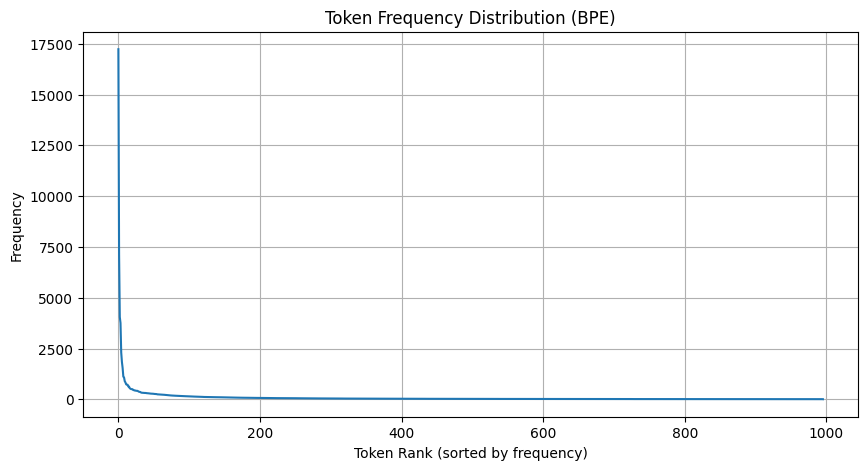

In [107]:

# Flatten all token ids from all entries in tokenized_c
all_token_ids_s = [token_id for entry in tokenized_s for token_id in entry.ids]

# Count frequency of each token id
token_counts_s = Counter(all_token_ids_s)

# Sort tokens by frequency
sorted_tokens_s = sorted(token_counts_s.items(), key=lambda x: x[1], reverse=True)
token_ids_sorted_s, frequencies_s = zip(*sorted_tokens_s)

plt.figure(figsize=(10, 5))
plt.plot(frequencies_s)
plt.xlabel("Token Rank (sorted by frequency)")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE)")
plt.grid(True)
plt.show()

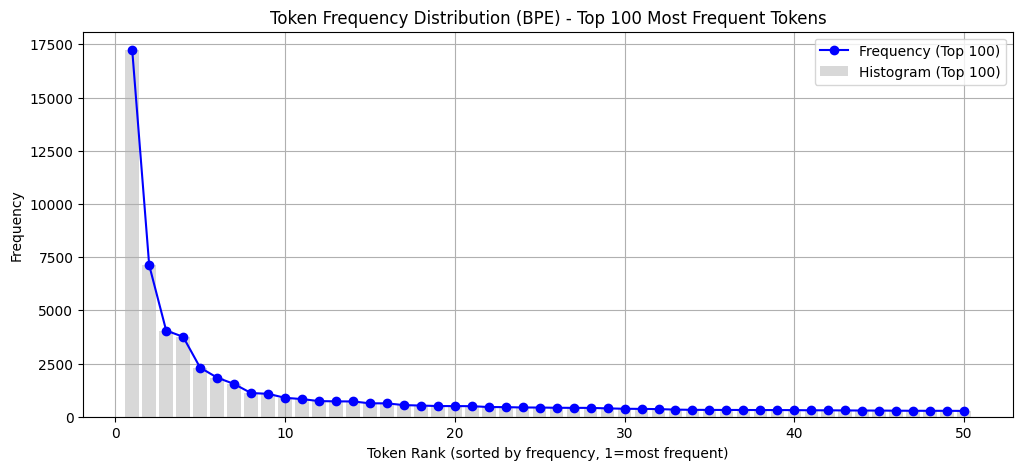

In [116]:
# Get the top 100 most frequent tokens and their frequencies (already sorted by frequency)
top_100 = sorted_tokens_s[:50]
top_token_ids_s, top_frequencies_s = zip(*top_100)

plt.figure(figsize=(12, 5))
plt.bar(range(1, 51), top_frequencies_s, color='gray', alpha=0.3, label='Histogram (Top 100)')
plt.plot(range(1, 51), top_frequencies_s, color='blue', marker='o', label='Frequency (Top 100)')
plt.xlabel("Token Rank (sorted by frequency, 1=most frequent)")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE) - Top 100 Most Frequent Tokens")
plt.grid(True)
plt.legend()
plt.show()

In [111]:
# Convert from token id to actual token for the top 10 most frequent tokens
top_10 = sorted_tokens_s[:10]
top_token_ids_10, top_frequencies_10 = zip(*top_10)

# Get the actual tokens from the tokenizer_s model
top_tokens_10 = [tokenizer_s.id_to_token(token_id) for token_id in top_token_ids_10]

# Create a DataFrame for a nice table
df_top10 = pd.DataFrame({
    'Rank': range(1, 11),
    'Token': top_tokens_10,
    'Token ID': top_token_ids_10,
    'Frequency': top_frequencies_10
})

display(df_top10)

,Rank,Token,Token ID,Frequency
0,1,k,7,17231
1,2,kk,17,7121
2,3,i,6,4050
3,4,kkk,25,3755
4,5,kkkk,19,2307
5,6,ii,18,1838
6,7,kkkkk,35,1539
7,8,kkkkkk,38,1113
8,9,iii,34,1077
9,10,l,8,889


<h5> Visualise Tokens


In [33]:
# set Y labels
anno_label_dict = pd.read_csv(
    "/data/UKBB/kyra/capture24/annotation-label-dictionary.csv",
    index_col='annotation', 
    dtype='string'
)

# Map annotations using Willetts' labels  (see paper reference at the bottom)
Y = anno_label_dict.loc[Y, 'label:Willetts2018'].to_numpy()

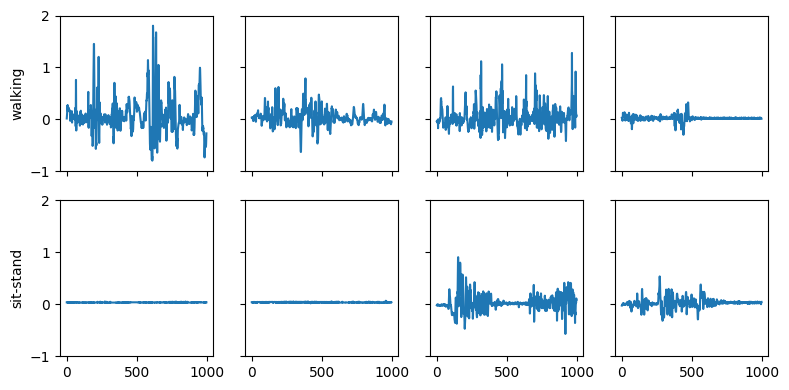

In [149]:
# Only plot 4 examples each for "walk" and "sit"
np.random.seed(234)
NPLOTS = 4

# Find unique labels
unqY = np.unique(Y)

# Only keep "walk" and "sit"
target_labels = ["walking", "sit-stand"]
fig, axs = plt.subplots(len(target_labels), NPLOTS, sharex=True, sharey=True, figsize=(8, 4))

for i, y in enumerate(target_labels):
    idxs = np.random.choice(np.where(Y == y)[0], size=NPLOTS, replace=False)
    axs[i, 0].set_ylabel(y)
    for x, ax in zip(norm_M[idxs], axs[i]):
        ax.plot(x[:1000])
        ax.set_ylim(-1, 2)

fig.tight_layout()
plt.show()

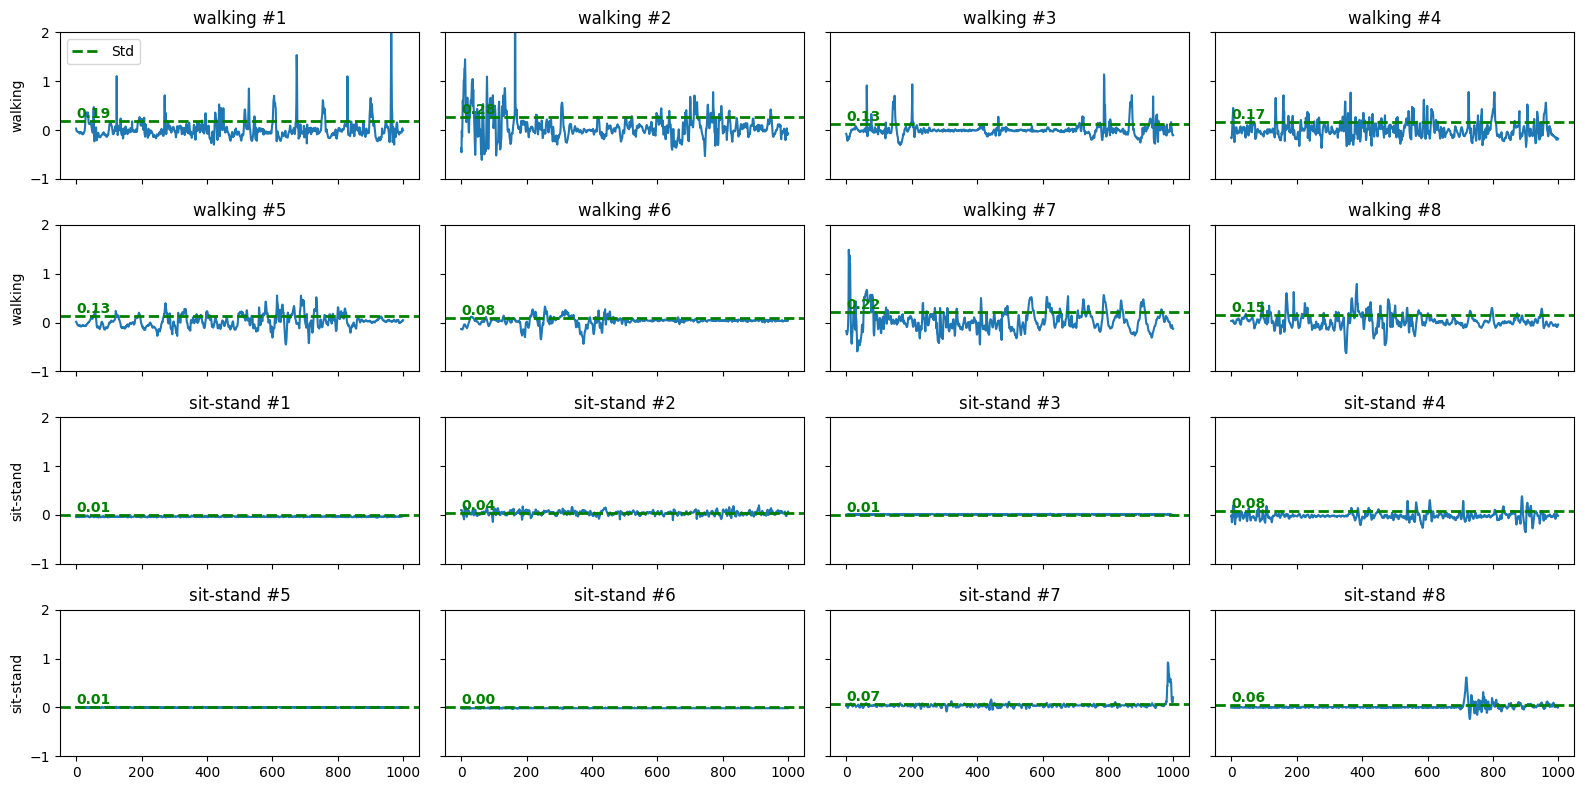

In [178]:
# Plot 8 examples each for "walking" and "sit-stand" in a 4x4 grid (total 16 plots)
np.random.seed(243)
NPLOTS = 8

target_labels = ["walking", "sit-stand"]
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(16, 8))

for i, y in enumerate(target_labels):
    idxs = np.random.choice(np.where(Y == y)[0], size=NPLOTS, replace=False)
    for j, idx in enumerate(idxs):
        row = j // 4 + i * 2  # 0-3 for walking, 2-3 for sit-stand
        col = j % 4
        ax = axs[row, col]
        x = norm_M[idx][:1000]
        ax.plot(x)
        ax.set_ylim(-1, 2)
        std_val = np.std(x)
        ax.axhline(std_val, color='green', linestyle='--', linewidth=2, label='Std')
        # Print the std value next to the std line
        ax.text(0, std_val, f"{std_val:.2f}", color='green', va='bottom', ha='left', fontsize=10, fontweight='bold')
        ax.set_title(f"{y} #{j+1}")
        if col == 0:
            ax.set_ylabel(y)
        if row == 0 and col == 0:
            ax.legend()

fig.tight_layout()
plt.show()

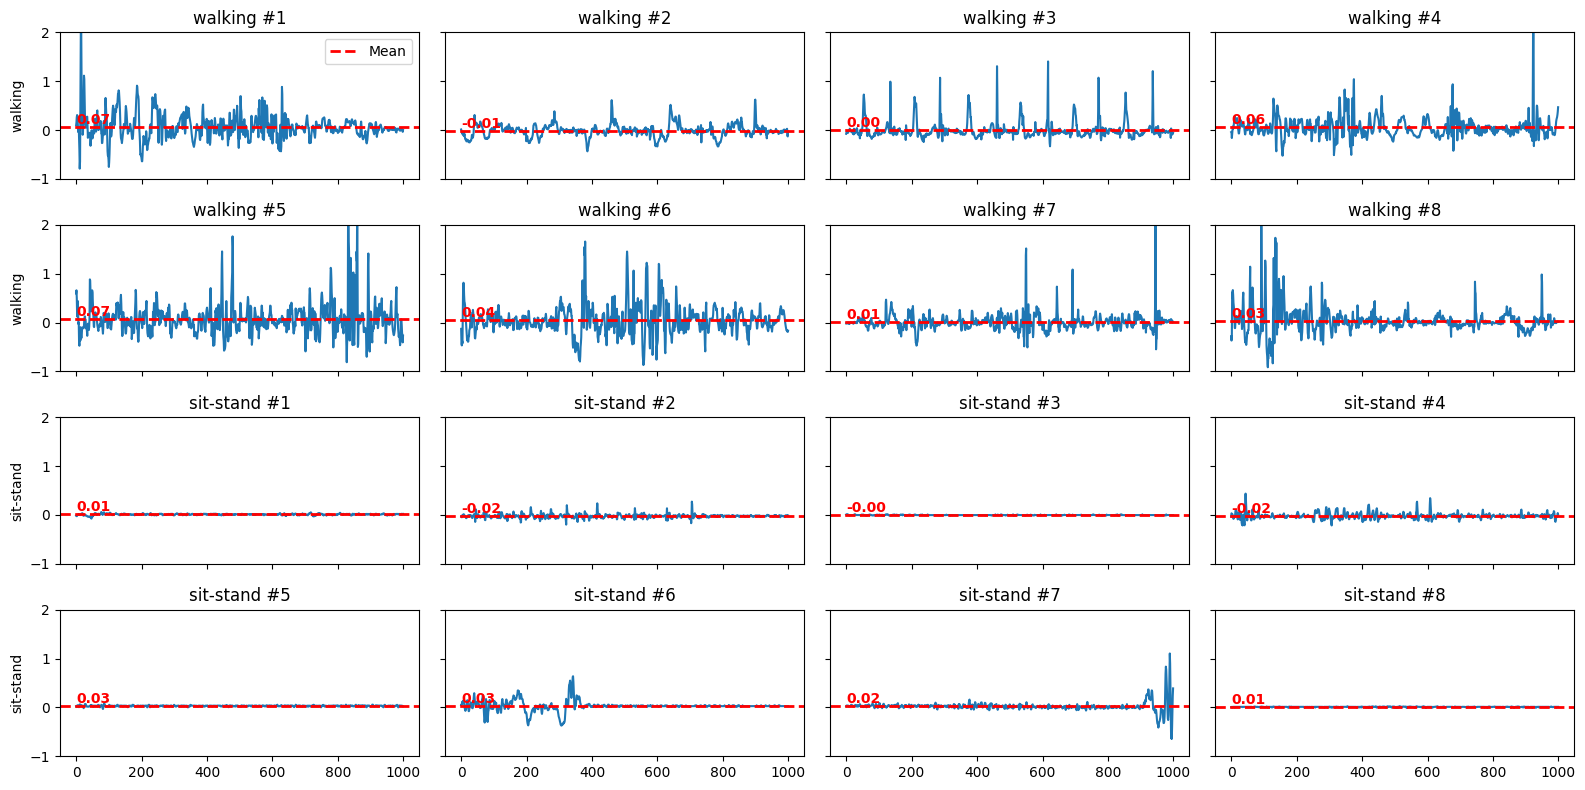

In [176]:
# Plot 8 examples each for "walking" and "sit-stand" in a 4x4 grid (total 16 plots)
np.random.seed(24)
NPLOTS = 8

target_labels = ["walking", "sit-stand"]
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(16, 8))

for i, y in enumerate(target_labels):
    idxs = np.random.choice(np.where(Y == y)[0], size=NPLOTS, replace=False)
    for j, idx in enumerate(idxs):
        row = j // 4 + i * 2  # 0-3 for walking, 2-3 for sit-stand
        col = j % 4
        ax = axs[row, col]
        x = norm_M[idx][:1000]
        ax.plot(x)
        ax.set_ylim(-1, 2)
        mean_val = np.mean(x)
        ax.axhline(mean_val, color='red', linestyle='--', linewidth=2, label='Mean')
        # Print the mean value next to the mean line
        ax.text(0, mean_val, f"{mean_val:.2f}", color='red', va='bottom', ha='left', fontsize=10, fontweight='bold')
        ax.set_title(f"{y} #{j+1}")
        if col == 0:
            ax.set_ylabel(y)
        if row == 0 and col == 0:
            ax.legend()

fig.tight_layout()
plt.show()

<h3> Standard Deviation Cut Points

In [58]:
#magnitude cuts for tokens
sd_cuts=pd.read_csv("sd_cut_points.csv")
labs_sd = list(string.ascii_lowercase[:len(sd_cuts)])

load data

In [6]:
X, Y, T = utils.make_windows(data, winsec=2)

compression

In [7]:

M= np.linalg.norm(X, axis=2)

norm_M= M-1

window_std= np.std(norm_M, axis=1)


labels and string

(37350,)

In [63]:
labels_sd=assign_labels(window_std, sd_cuts, labs_sd)
string_sd=labels_to_string(labels_sd)

In [13]:
string_sd

' b b b b b b b b b bb b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b b bhgfged chcc bcc egigbb bbbbbb b b ccc c ejeeedec b b b bb b b b b b bfffcb b b b b b b b b b b b b b b bbbb b b b b bbb bb b b b bbbbbbb bbbbbbbbbbbbbbbbbbb bbb b b bbbbbb bbbbbbbbb bbbbbbbb b bbbbbbb b bb b bb b b bb bbbbbbbbbbb bbbbccc b b b bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb bbbbbbbbbbbbbbbbbbbbbbbbbbbbb b bbbbb b bbb bb b bbbb bbb b b b b bbbb b bbbbbb b b b b bbb b bbbb bb b b b bbb b b b b b b bbbbbbbbbbb b b b bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb bbbbbbbbb bbbbb bbbbbbbbbbb bbbbb bbbbbbb bbbbbbbbb bbbb bbb b bb b b bbbbbbbbb bbb b b b bbbb b b b b b b b bbbb bb b b b bbb b b b b b b b b b b bb bb bb b bbb bb b bfdihhdeeegheikklkkkkkfghkijiijhgjhkjhgegighiihjgjhgjhjgjfidffgfceehffhfdb fecccdddcdfchggeddgihgiefdhiiiigbgifefhhhgejifgigghihcfiihhiijjkjihhjhijijiiihjgeiigijfigkhiegdcceifhfiihigdceddeieghfdegeigfeiicbbfjeghee

BPE

In [14]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

# Build the tokenizer
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.BpeTrainer(vocab_size=8000, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
corpus_iterator= string_sd.split()


# Train on your own corpus
tokenizer.train_from_iterator(corpus_iterator, trainer)

# Encode
output = tokenizer.encode(string_sd)
print(output.tokens)
print(len(output.ids))




['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'bb', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'bhgfged', 'chcc', 'bcc', 'egigbb', 'bbbbbb', 'b', 'b', 'ccc', 'c', 'ejeeedec', 'b', 'b', 'b', 'bb', 'b', 'b', 'b', 'b', 'b', 'bfffcb', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'bbbb', 'b', 'b', 'b', 'b', 'bbb', 'bb', 'b', 'b', 'b', 'bbbbbbb', 'bbbbbbbbbbbbbbbbbbb', 'bbb', 'b', 'b', 'bbbbbb', 'bbbbbbbbb', 'bbbbbbbb', 'b', 'bbbbbbb', 'b', 'bb', 'b', 'bb', 'b', 'b', 'bb', 'bbbbbbbbbbb', 'bbbbccc', 'b', 'b', 'b', 'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb', 'bbbbbbbbbbbbbbbbbbbbbbbbbbbbb', 'b', 'bbbbb', 'b', 'bbb', 'bb', 'b', 'bbbb', 'bbb', 'b', 'b', 'b', 'b', 'bbbb', 'b', 'bbbbbb', 'b', 'b', 'b', 'b', 'bbb', 'b', 'bbbb', 'bb', 'b', 'b', 'b', 'bbb', 'b', 'b', 'b', 'b', 'b', 'b', '

In [15]:
encoded_outputs = [tokenizer.encode(text) for text in corpus_iterator]
token_ids = [token for enc in encoded_outputs for token in enc.ids]

In [16]:
from collections import Counter

token_counts = Counter(token_ids)

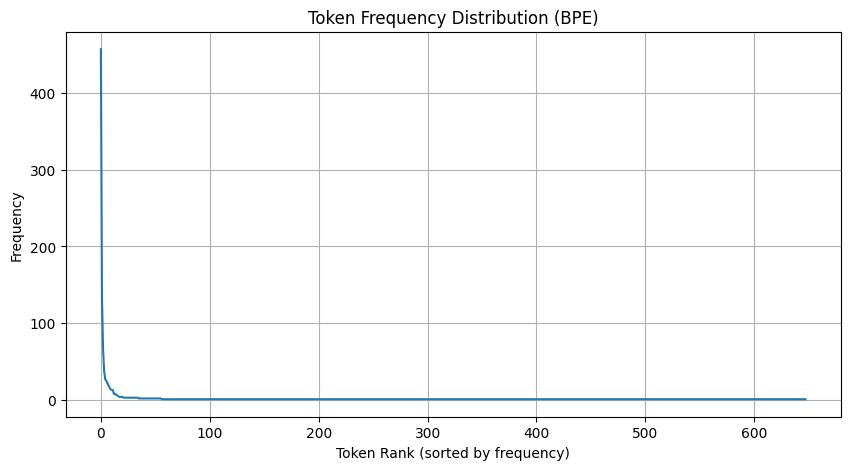

In [17]:
import matplotlib.pyplot as plt

# Sort tokens by frequency
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
token_ids_sorted, frequencies = zip(*sorted_tokens)

plt.figure(figsize=(10, 5))
plt.plot(frequencies)
plt.xlabel("Token Rank (sorted by frequency)")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE)")
plt.grid(True)
plt.show()

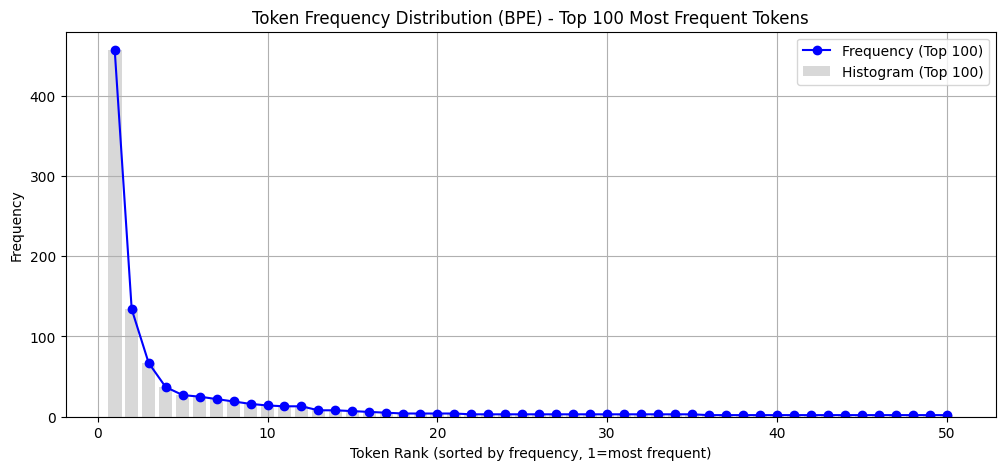

In [18]:
# Get the top 100 most frequent tokens and their frequencies (already sorted by frequency)
top_100 = sorted_tokens[:50]
top_token_ids, top_frequencies = zip(*top_100)

plt.figure(figsize=(12, 5))
plt.bar(range(1, 51), top_frequencies, color='gray', alpha=0.3, label='Histogram (Top 100)')
plt.plot(range(1, 51), top_frequencies, color='blue', marker='o', label='Frequency (Top 100)')
plt.xlabel("Token Rank (sorted by frequency, 1=most frequent)")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE) - Top 100 Most Frequent Tokens")
plt.grid(True)
plt.legend()
plt.show()

Whole Corpus

get full corpus

In [85]:
corpus=[]
pid=[]
cuts= sd_cuts

for i in os.listdir("/data/UKBB/kyra/capture24/"):

    if i.startswith("P") and i.endswith(".csv.gz"):

        data = utils.load_data(f'/data/UKBB/kyra/capture24/{i}')  # Use the current file name
        pid.append(i)
        X, Y, T = utils.make_windows(data, winsec=10)
        M = np.linalg.norm(X, axis=2)
        norm_M = M - 1
        window_mean = np.std(norm_M, axis=1)
        labs = list(string.ascii_lowercase[:len(cuts)])
        labels = assign_labels(window_mean, cuts, labs)
        result_string = labels_to_string(labels)
        corpus.append(result_string)  


In [86]:
#export corpus to csv.

# Create a DataFrame where each row is a pid and its corresponding corpus string
df = pd.DataFrame({'pid': pid, 'token_string': corpus})
df.to_csv('pid_token_string.csv', index=False)
df.head()

pid  \
0  P030.csv.gz   
1  P036.csv.gz   
2  P113.csv.gz   
3  P048.csv.gz   
4  P099.csv.gz   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

train tokenizer

In [88]:
corpus_joined= " ".join(corpus)

from tokenizers import Tokenizer, models, trainers, pre_tokenizers

tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer= trainers.BpeTrainer(vocab_size=1000, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
corpus_iterator= corpus_joined.split()


# Train on your own corpus
tokenizer.train_from_iterator(corpus_iterator, trainer)

# Encode
output= tokenizer.encode(result_string)
print(output.tokens)
print(len(output.ids))




['cccccccccccccccccccccccccccccccc', 'cccccccc', 'bbbbccc', 'bbbbbbbb', 'cc', 'bbbbc', 'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb', 'bbbbbbbbbbbbbbbbbbbbbbbb', 'bc', 'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb', 'c', 'bbbbbbbbbbbc', 'bcbbbc', 'bbbbbc', 'bbbbcc', 'bbbbbbbc', 'dbc', 'bc', 'bbbbbbbbbbbc', 'bccc', 'bbbbc', 'bbbbbbbbbbbb', 'bbbcbc', 'bd', 'bc', 'ddd', 'bb', 'bcc', 'bbbbccc', 'bbc', 'bbbbbbbbbbbb', 'bbcbc', 'd', 'de', 'bbbcc', 'dc', 'bbc', 'dcc', 'bbbc', 'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb', 'bbbbb', 'b', 'b', 'bb', 'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb', 'bcbb', 'c', 'db', 'bb', 'bd', 'bbbbbbbbc', 'bbbbbbbbbbbb', 'bcbbbc', 'bbbbc', 'bbbbbbbbbbbbbbbbbbbbbbbb', 'bbbbbbbbbbbbbbbbbb', 'cd', 'bbbbb', 'b', 'bbb', 'bb', 'b', 'b', 'b', 'bbb', 'bc', 'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb', 'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb', 'bb

In [89]:
# Tokenize each entry in corpus_c using the trained tokenizer_c
tokenized= [tokenizer.encode(i) for i in corpus]

In [90]:
tokenizer.save("trained_tokenizer.json")

In [ ]:
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file("trained_tokenizer.json")

combine tokenized output with pid to export

<h3>Exploratory Analysis of Tokens

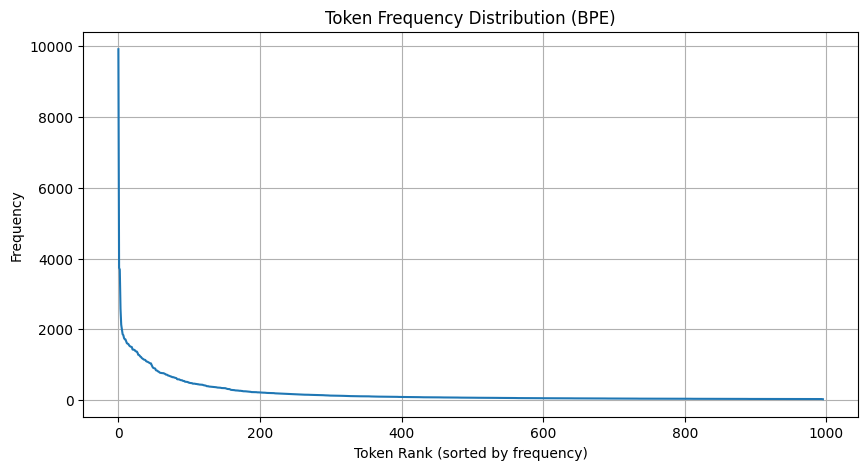

In [24]:

# Flatten all token ids from all entries in tokenized_c
all_token_ids = [token_id for entry in tokenized for token_id in entry.ids]

# Count frequency of each token id
token_counts= Counter(all_token_ids)

# Sort tokens by frequency
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
token_ids_sorted, frequencies = zip(*sorted_tokens)

plt.figure(figsize=(10, 5))
plt.plot(frequencies)
plt.xlabel("Token Rank (sorted by frequency)")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE)")
plt.grid(True)
plt.show()

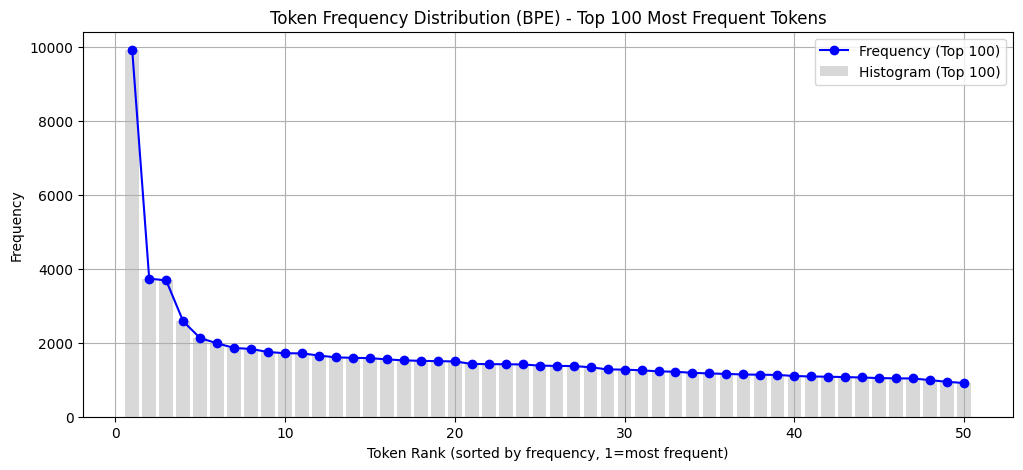

In [25]:
# Get the top 100 most frequent tokens and their frequencies (already sorted by frequency)
top_100 = sorted_tokens[:50]
top_token_ids, top_frequencies= zip(*top_100)

plt.figure(figsize=(12, 5))
plt.bar(range(1, 51), top_frequencies, color='gray', alpha=0.3, label='Histogram (Top 100)')
plt.plot(range(1, 51), top_frequencies, color='blue', marker='o', label='Frequency (Top 100)')
plt.xlabel("Token Rank (sorted by frequency, 1=most frequent)")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE) - Top 100 Most Frequent Tokens")
plt.grid(True)
plt.legend()
plt.show()


In [27]:
# Convert from token id to actual token for the top 10 most frequent tokens
top_10 = sorted_tokens[:20]
top_token_ids_10, top_frequencies_10 = zip(*top_10)

# Get the actual tokens from the tokenizer_s model
top_tokens_10 = [tokenizer.id_to_token(token_id) for token_id in top_token_ids_10]

# Create a DataFrame for a nice table
df_top10 = pd.DataFrame({
    'Rank': range(1, 21),
    'Token': top_tokens_10,
    'Token ID': top_token_ids_10,
    'Frequency': top_frequencies_10
})

df_top10

,Rank,Token,Token ID,Frequency
0,1,b,4,9918
1,2,bb,16,3737
2,3,c,5,3687
3,4,d,6,2582
4,5,e,7,2127
5,6,bbb,37,1986
6,7,cb,31,1860
7,8,cc,17,1833
8,9,f,8,1750
9,10,ff,22,1718


Visualise tokens in practice 

In [13]:
def wearable_tokenizer(X, cuts, tokenizer):
    """
    Given input X, cut points, and a trained tokenizer,
    returns the encoded output for the generated string.
    """
    M = np.linalg.norm(X, axis=2)
    norm_M = M - 1
    window_mean = np.std(norm_M, axis=1)
    labs = list(string.ascii_lowercase[:len(cuts)])
    labels = assign_labels(window_mean, cuts, labs)
    result_string = labels_to_string(labels)
    # Encode the generated string
    output = tokenizer.encode(result_string)
    return output

In [35]:
X_win, Y_win, T_win = utils.make_windows(data, winsec=40)

M_win= np.linalg.norm(X_win, axis=2)

norm_M_win= M_win-1

Y_win= anno_label_dict.loc[Y_win, 'label:Willetts2018'].to_numpy()


In [96]:
indx=1400

In [95]:
Y_win.shape

(1868,)

In [30]:
M_win.shape

#200 observation for 2 seconds

(1868, 4000)

In [97]:
M_win[indx].shape


(4000,)

In [ ]:
#e.g of first window

#get each 2 secons window
# Divide M_win[1] into chunks of 200 observations each

window_size = 200
chunks = [M_win[indx][i:i+window_size] for i in range(0, len(M_win[1]), window_size)]

# Get the standard deviation of each chunk
chunk_stds = [np.std(chunk) for chunk in chunks]



In [78]:
# Convert chunk_stds to a numpy array
chunk_stds = np.array([np.std(chunk) for chunk in chunks])
chunk_stds

array([0.02496355, 0.01244401, 0.01744846, 0.01459541, 0.01603536,
       0.03890719, 0.02238472, 0.01812421, 0.02120467, 0.0249797 ,
       0.0166903 , 0.01372539, 0.00913534, 0.01067576, 0.01365252,
       0.01838903, 0.01742358, 0.01082074, 0.007699  , 0.01961602],
      dtype=float32)

In [79]:
chunk_stds.shape

(20,)

In [80]:
# Make sure sd_cuts and labs_sd are numpy arrays with default integer indices
sd_cuts_arr = np.array(sd_cuts).flatten()
labs_sd_arr = np.array(labs_sd)

labels = assign_label(chunk_stds, sd_cuts_arr, labs_sd_arr)

In [81]:
labels 

[np.str_('d'),
 np.str_('c'),
 np.str_('d'),
 np.str_('d'),
 np.str_('d'),
 np.str_('d'),
 np.str_('d'),
 np.str_('d'),
 np.str_('d'),
 np.str_('d'),
 np.str_('d'),
 np.str_('c'),
 np.str_('c'),
 np.str_('c'),
 np.str_('c'),
 np.str_('d'),
 np.str_('d'),
 np.str_('c'),
 np.str_('b'),
 np.str_('d')]

In [ ]:
import re

def labels_to_string_visual(labels):
    """
    Convert a list of labels to a string, preserving all spaces (do not collapse consecutive spaces).
    """
    return ''.join(labels)

In [83]:
window_string=labels_to_string_visual(labels)

In [94]:
window_string

'dcdddddddddccccddcbd'

In [92]:
tokenized_window=tokenizer.encode(window_string)

In [93]:
tokenized_window.tokens

['dc', 'dddddddd', 'dcccc', 'ddcb', 'd']

/tmp/ipykernel_2758854/869334789.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  token_colors = plt.cm.get_cmap('tab20', len(token_spans))


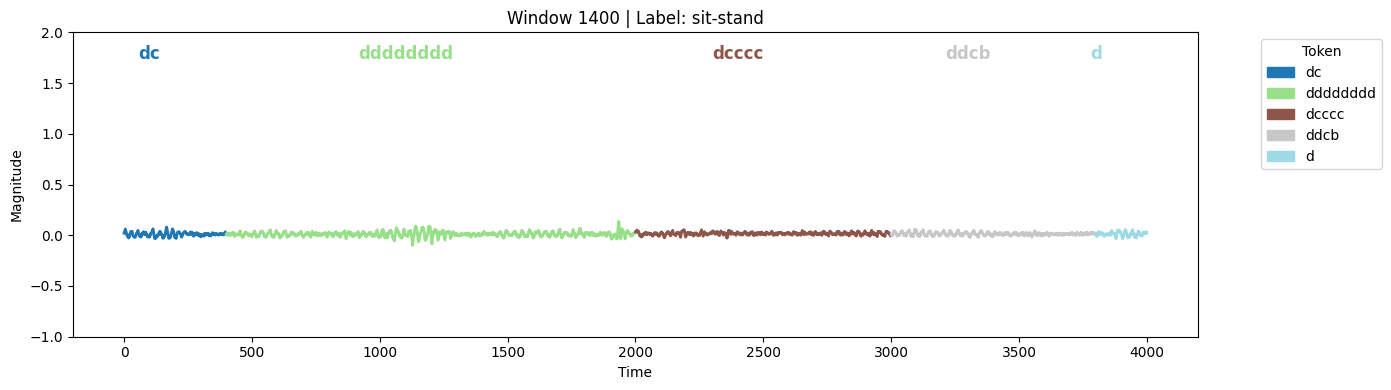

In [108]:
import matplotlib.patches as mpatches

indx = 1400
window_size = 200
x_data = norm_M_win[indx]
n_windows = len(x_data) // window_size

# window_string: one character per window (length n_windows)
# tokenized_window.tokens: list of tokens (each token is a string of one or more characters from window_string)

# Map each window to its character
window_chars = list(window_string)

# Build a list of (start_window, end_window, token_str) for each token
token_spans = []
pos = 0
for token in tokenized_window.tokens:
    length = len(token)
    token_spans.append((pos, pos + length, token))
    pos += length

# Assign a color to each token (not character)
token_colors = plt.cm.get_cmap('tab20', len(token_spans))

plt.figure(figsize=(14, 4))
for i, (start, end, token) in enumerate(token_spans):
    start_idx = start * window_size
    end_idx = end * window_size
    plt.plot(range(start_idx, end_idx), x_data[start_idx:end_idx], color=token_colors(i), linewidth=2)
    # Move the token label down a bit (e.g., y=1.7 instead of 1.9)
    mid = (start + end - 1) / 2
    plt.text(mid * window_size, 1.7, token, ha='center', va='bottom', fontsize=12, color=token_colors(i), fontweight='bold', rotation=0)

plt.ylim(-1, 2)
plt.title(f"Window {indx} | Label: {Y_win[indx]}")
plt.xlabel("Time")
plt.ylabel("Magnitude")

# Create legend for tokens
handles = [mpatches.Patch(color=token_colors(i), label=token) for i, (_, _, token) in enumerate(token_spans)]
plt.legend(handles=handles, title="Token", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipykernel_2758854/2297740516.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  token_colors = plt.cm.get_cmap('tab20', len(token_spans))


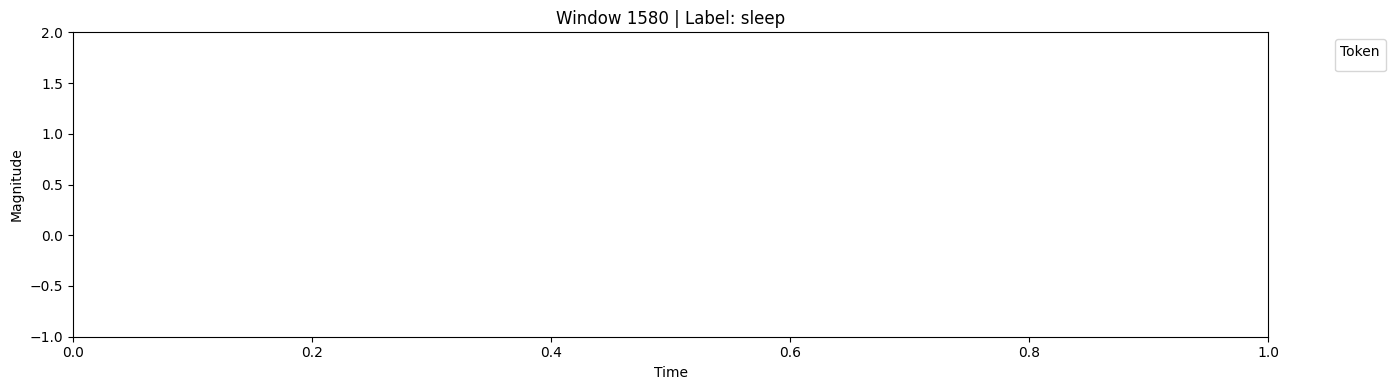

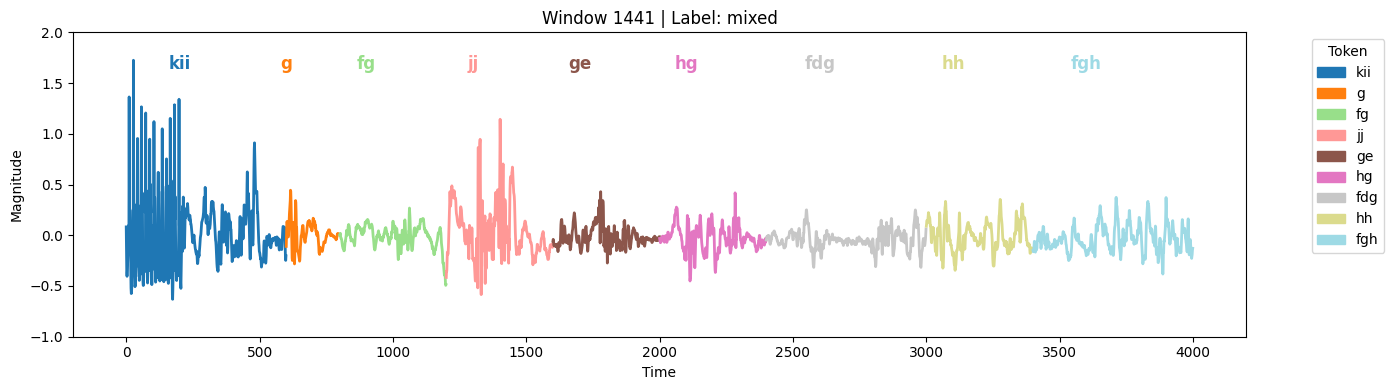

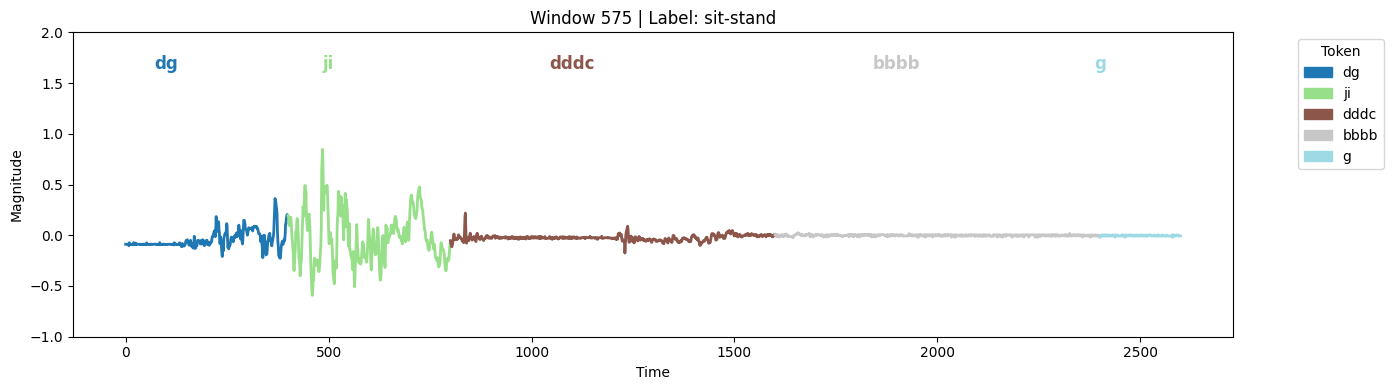

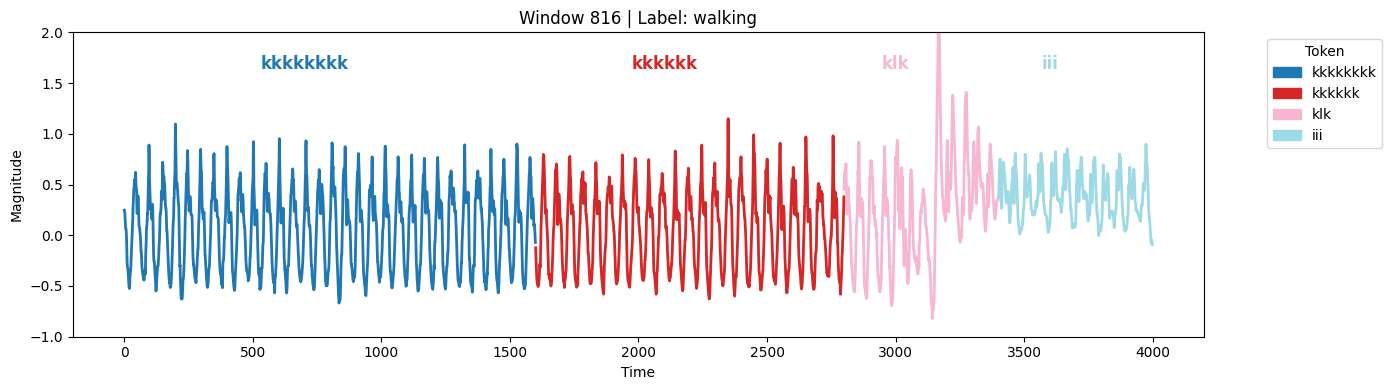

In [117]:
import matplotlib.patches as mpatches

np.random.seed(587)
n_examples = 4  # Number of random examples to plot
random_indices = np.random.choice(len(norm_M_win), size=n_examples, replace=False)

window_size = 200

for plot_num, indx in enumerate(random_indices):
    x_data = norm_M_win[indx]
    n_windows = len(x_data) // window_size

    # Get the window string and tokens for this index
    # (Assume you have a function or code to generate window_string and tokenized_window for each indx)
    chunks = [M_win[indx][i:i+window_size] for i in range(0, len(M_win[indx]), window_size)]
    chunk_stds = [np.std(chunk) for chunk in chunks]
    labels = assign_label(np.array(chunk_stds), np.array(sd_cuts).flatten(), np.array(labs_sd))
    window_string = labels_to_string_visual(labels)
    tokenized_window = tokenizer.encode(window_string)

    # Build token spans
    token_spans = []
    pos = 0
    for token in tokenized_window.tokens:
        length = len(token)
        token_spans.append((pos, pos + length, token))
        pos += length

    token_colors = plt.cm.get_cmap('tab20', len(token_spans))

    plt.figure(figsize=(14, 4))
    for i, (start, end, token) in enumerate(token_spans):
        start_idx = start * window_size
        end_idx = end * window_size
        plt.plot(range(start_idx, end_idx), x_data[start_idx:end_idx], color=token_colors(i), linewidth=2)
        mid = (start + end - 1) / 2
        plt.text(mid * window_size, 1.6, token, ha='center', va='bottom', fontsize=12, color=token_colors(i), fontweight='bold', rotation=0)

    plt.ylim(-1, 2)
    plt.title(f"Window {indx} | Label: {Y_win[indx]}")
    plt.xlabel("Time")
    plt.ylabel("Magnitude")

    handles = [mpatches.Patch(color=token_colors(i), label=token) for i, (_, _, token) in enumerate(token_spans)]
    plt.legend(handles=handles, title="Token", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2758854/4027342423.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


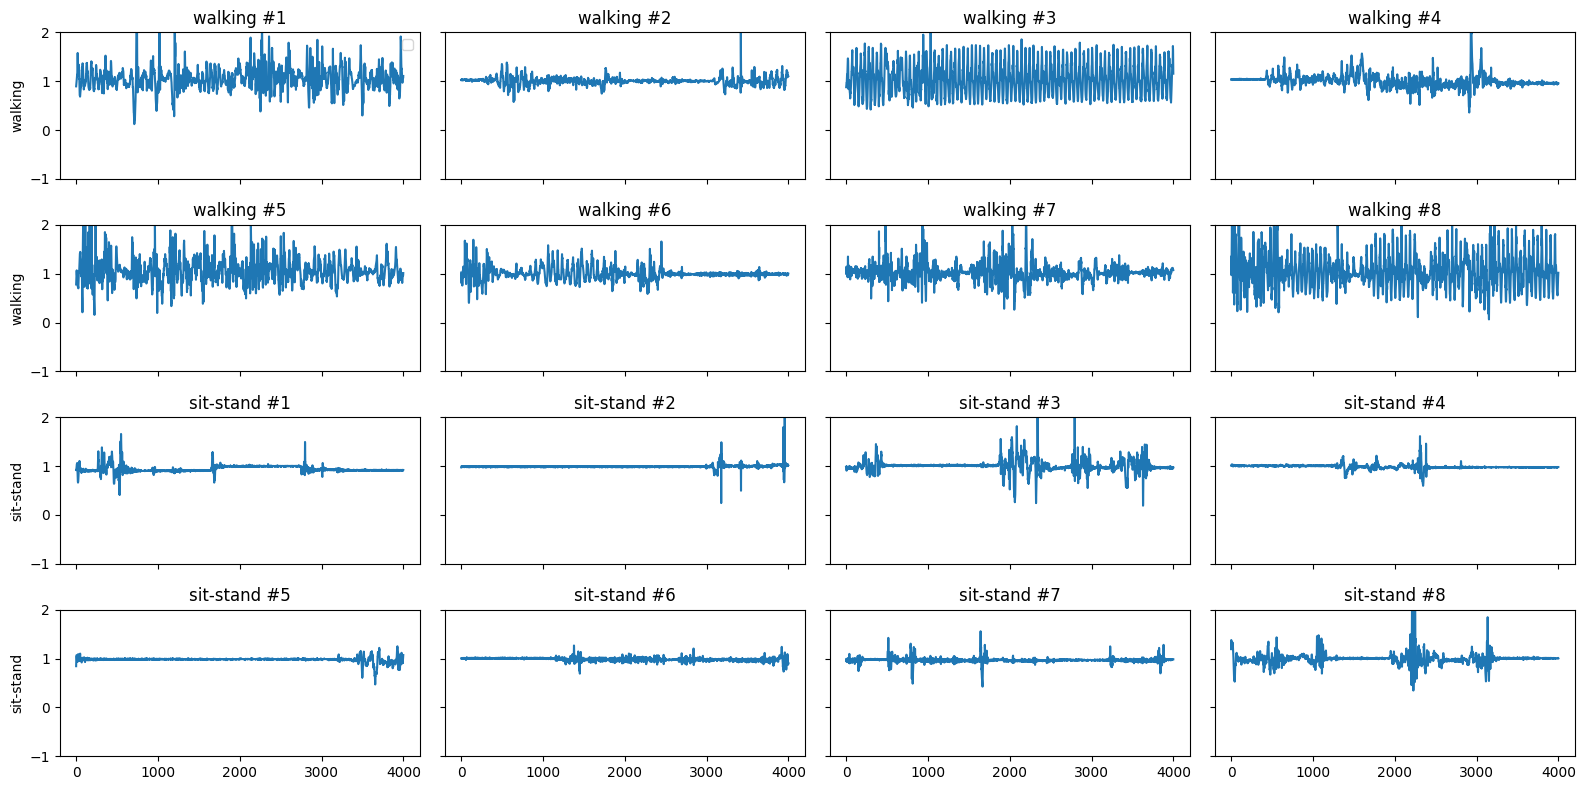

In [40]:
# Plot 8 examples each for "walking" and "sit-stand" in a 4x4 grid (total 16 plots)
np.random.seed(24)
NPLOTS = 8

target_labels = ["walking", "sit-stand"]
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(16, 8))

for i, y in enumerate(target_labels):
    idxs = np.random.choice(np.where(Y_win == y)[0], size=NPLOTS, replace=False)
    for j, idx in enumerate(idxs):
        row = j // 4 + i * 2  # 0-3 for walking, 2-3 for sit-stand
        col = j % 4
        ax = axs[row, col]
        x = M_win[idx][:4000]
        ax.plot(x)
        ax.set_ylim(-1, 2)
        mean_val = np.mean(x)
        # Print the mean value next to the mean line

        ax.set_title(f"{y} #{j+1}")
        if col == 0:
            ax.set_ylabel(y)
        if row == 0 and col == 0:
            ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
#divide each 20 second window into 2 seconds, get the appropriate character for each window- concact to a string, tokenized. 
#Basically run the tokenized on just the 20 seconds, but dont shrink large spaces, then find length of each token but a line inbetwen and color ?


In [ ]:
labels_to_string_visual(labels)
